In [1]:
import pandas as pd
from src.data_collection import deg_utils, stringdb_api
import networkx as nx
from src.graph.graph_util import *
import config.config as config
from src.visualization.plots import plot_dist
from IPython.display import Image, display

import dill
dill.load_session("01_session.pkl")

# Graph Construction
This notebook focuses on the construction of the protein-protein interaction network of the up and down regulated genes associated to the experiments.

Starting from the **Bulk RNA-seq data** of different tissues provided by the researcher, and from the STRING database i'm going to build the corresponding network(s) related to the **liver tissue**.

In [13]:
deg_df = deg_utils.preprocess_bulk_rna_seq_data(0.05, 0.585, contrast=["group", "302b", "Aging"], file=config.aging_vs_302_PROCESSED_BULK_RNA_SEQ_FILE)  # log2fc of 0.585 corresponds to a 1.5-fold change
deg_df

,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8,Jak3,276.376494,-1.278192,0.359539,-3.555087,0.000378,0.008552
10,Ahnak,284.381156,-0.895891,0.286510,-3.126910,0.001767,0.024266
11,Atp6v0d2,285.854525,-3.160026,0.995580,-3.174056,0.001503,0.021984
14,Fgg,69476.512553,-1.269595,0.403712,-3.144808,0.001662,0.023358
30,Hectd2os,68.877005,2.062805,0.483311,4.268071,0.000020,0.001063
...,...,...,...,...,...,...,...
15529,Gfod2,120.223963,-1.007211,0.323997,-3.108702,0.001879,0.025183
15545,St3gal1,1493.787853,-0.718271,0.223594,-3.212392,0.001316,0.020066
15550,Peg3,68.293330,-1.787922,0.595048,-3.004666,0.002659,0.032388
15595,Ypel3,786.527320,0.896559,0.274292,3.268629,0.001081,0.017523


In [14]:
downregulated_genes = deg_utils.get_downregulated_genes(deg_df)
upregulated_genes = deg_utils.get_upregulated_genes(deg_df)
print("Downregulated: ", len(downregulated_genes), "Upregulated: ", len(upregulated_genes))
intersection = list(set(downregulated_genes["name"]) & set(upregulated_genes["name"]))
print("Intersection: ", len(intersection))

Downregulated:  835 Upregulated:  518
Intersection:  0


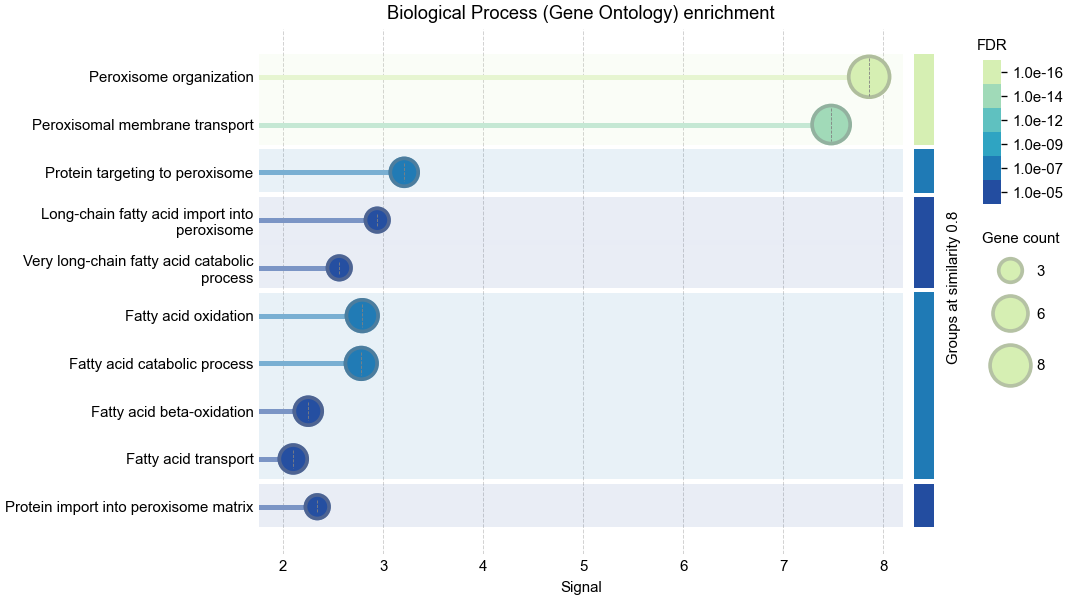

In [15]:
enrichment_figure = stringdb_api.get_enrichment_figure(downregulated_genes, ["KEGG", "Process"])
display(Image(data=enrichment_figure))

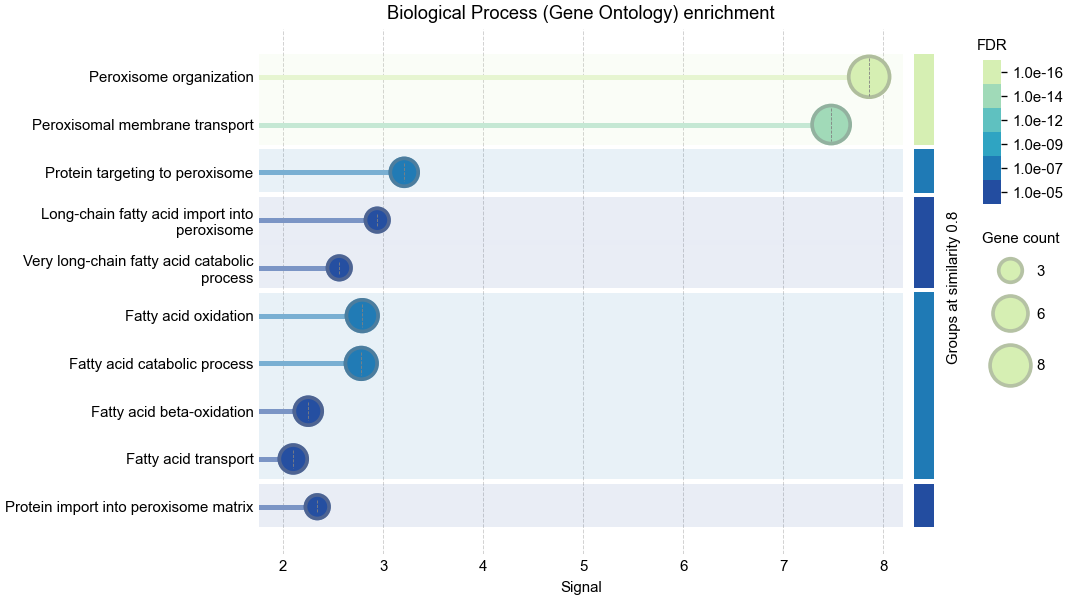

In [16]:
enrichment_figure = stringdb_api.get_enrichment_figure(upregulated_genes, ["KEGG", "Process"])
display(Image(data=enrichment_figure))

1. **Peroxisome organization:**
   This refers to how cells form, arrange, and maintain peroxisomes — small compartments that help break down fatty acids and detoxify harmful substances. Changes in this process can affect how well cells manage metabolism and oxidative stress.

2. **Peroxisomal membrane transport:**
   This describes how molecules move in and out of peroxisomes through their membrane. It’s important because peroxisomes need to import certain enzymes and export the products of their reactions to keep cellular metabolism balanced.

In [17]:
downregulated_graph = get_gene_graph(downregulated_genes.to_dict(orient="records"), config.LIVER_DOWNREGULATED_GRAPH_FILE_NAME)
upregulated_graph = get_gene_graph(upregulated_genes.to_dict(orient="records"), config.LIVER_UPREGULATED_GRAPH_FILE_NAME)

intersection_graph = nx.intersection(downregulated_graph, upregulated_graph)
print("Downregulated Nodes: ", len(downregulated_graph.nodes))
print("Upregulated Nodes: ", len(upregulated_graph.nodes))
print("Intersection Nodes: ", len(intersection_graph.nodes))

Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_downregulated_graph': 6858 nodes, 21862 edges
Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_upregulated_graph': 5871 nodes, 17408 edges
Downregulated Nodes:  6858
Upregulated Nodes:  5871
Intersection Nodes:  3934


In [18]:
combined_graph = nx.compose(downregulated_graph, upregulated_graph)
combined_graph.number_of_nodes(), combined_graph.number_of_edges()

(8795, 32313)

In [19]:
full_deg_dataset = deg_utils.preprocess_bulk_rna_seq_data(1, 0, contrast=["group", "302b", "Aging"], file=config.aging_vs_302_PROCESSED_BULK_RNA_SEQ_FILE)

neighbors = []
seed = []
for node in combined_graph.nodes.data():
    if node[1]["fold_change"] == 0.0:
        neighbors.append(node[1]["name"])
    else:
        seed.append(node[1]["name"])

print("Neighbors: ", len(neighbors), "Seed: ", len(seed))
neighbors_overlapped = full_deg_dataset["name"].isin(neighbors).sum()
print("Overlap between DEG study genes and extendend network genes: ", neighbors_overlapped)
print("New genes added: ", len(neighbors) - neighbors_overlapped)

Neighbors:  7710 Seed:  1085
Overlap between DEG study genes and extendend network genes:  5640
New genes added:  2070


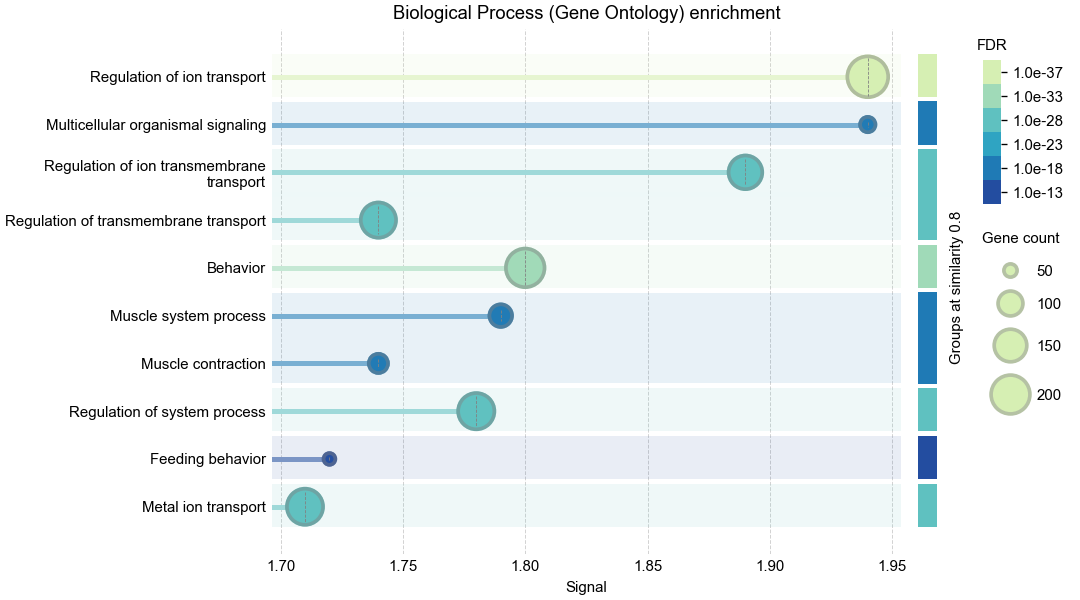

In [20]:
new_genes = list(set(neighbors) - set(full_deg_dataset["name"]))
enrichment_figure = stringdb_api.get_enrichment_figure(new_genes[71:], ["KEGG", "Process"])
len(new_genes[71:]) # Enrichment figure API has a limit of 2000 genes
display(Image(data=enrichment_figure))

# Degree Distribution Analysis

## Downregulated Genes

Graph has 6858 nodes and 21862 edges.

Degree analysis:
	Average degree: 6.38
	Max degree: 69
	Min degree: 0

Connectedness analysis:
	Number of connected components: 182
	Size of largest connected component: 6618
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 17
	Average shortest path length of largest connected component: 6.049726308687847

Clustering and Density analysis:
	Average clustering coefficient: 0.25379315182891415
	Graph density: 0.0009297972457638021


Centrality analysis:
	Average betweenness centrality: 0.000685888495747355
	Max betweenness centrality: 0.044797150295349177
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.1567657202140107
	Max closeness centrality: 0.23199390259423217
	Min closeness centrality: 0.0


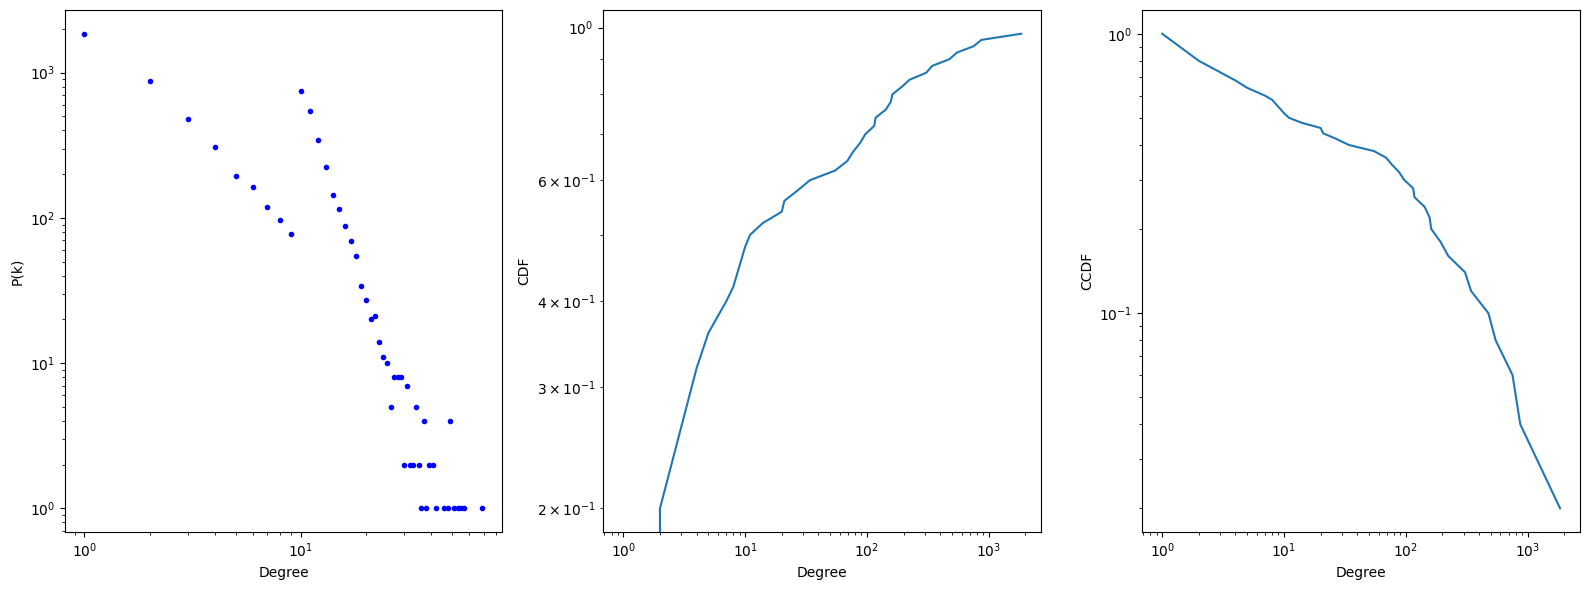

In [21]:
downregulated_graph_analysis = print_analysis(downregulated_graph)
plot_dist(downregulated_graph)

### Hub Nodes Enrichment Analysis

In [22]:
large_hub_nodes = get_nodes_with_certain_degree(downregulated_graph, (30, 69))
print("Number of Selected Hubs: ", len(large_hub_nodes))
print("Hubs: ", large_hub_nodes)

Number of Selected Hubs:  42
Hubs:  ['Jak2', 'Egfr', 'Crebbp', 'Src', 'F2', 'Alb', 'Itgb3', 'Fn1', 'Itgb1', 'Cd44', 'Tlr4', 'Hspa5', 'Rhoa', 'Rac2', 'Syk', 'Cd4', 'Tnf', 'Apoa1', 'Trp53', 'Cdc42', 'Grb2', 'Tjp1', 'Ptk2', 'Actb', 'Actg1', 'Kdr', 'Apob', 'Ptpn11', 'Ctnnb1', 'Hras', 'Kras', 'Dlg4', 'Tyrobp', 'Akt1', 'Prkacb', 'Prkaca', 'Hp', 'Traf6', 'Hdac1', 'Gnaq', 'Fau', 'Itpa']


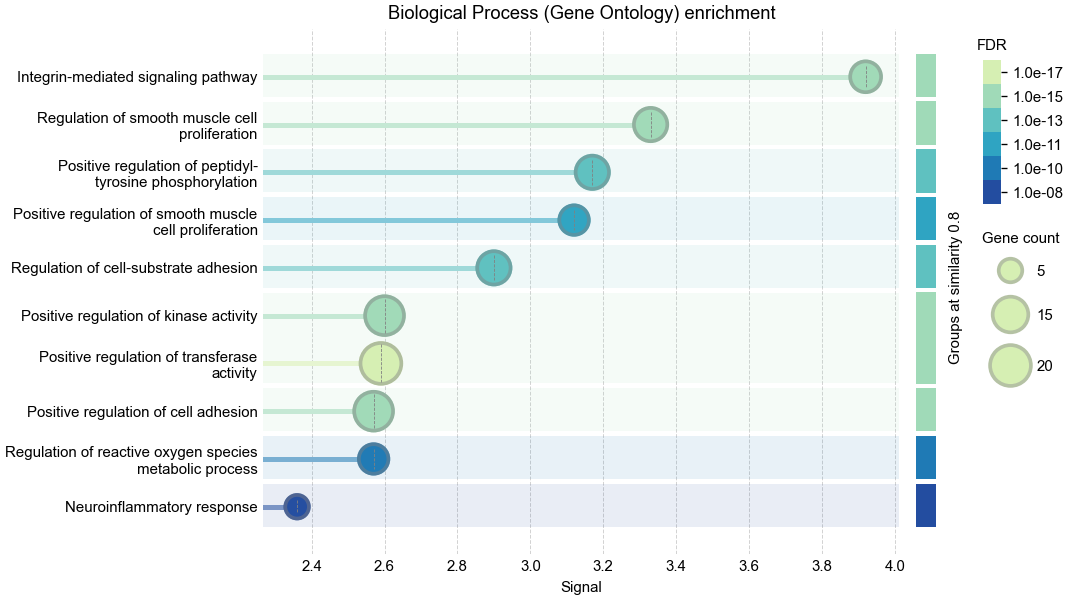

In [23]:
enrichment_figure = stringdb_api.get_enrichment_figure(large_hub_nodes, ["KEGG", "Process"])
display(Image(data=enrichment_figure))

This figure shows the results of a functional enrichment analysis, which identifies biological processes that are most active or overrepresented in our set of genes. Each row represents a biological process, and the circles indicate how strongly that process appears in our data.

Larger circles mean more genes are involved in that process, and lighter colors indicate stronger statistical significance.

In this case, the most enriched processes are mainly related to how cells communicate, attach to their surroundings, and grow or divide — for example, processes involving cell signaling, adhesion, and proliferation. We also see some involvement of stress or inflammatory responses.

Overall, these results suggest that the genes we analyzed are mostly connected to cellular communication and growth regulation, with some links to inflammation or stress-related activity.


## Upregulated Gene Network

Graph has 5871 nodes and 17408 edges.

Degree analysis:
	Average degree: 5.93
	Max degree: 55
	Min degree: 0

Connectedness analysis:
	Number of connected components: 129
	Size of largest connected component: 5686
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 14
	Average shortest path length of largest connected component: 6.456516042890762

Clustering and Density analysis:
	Average clustering coefficient: 0.25684992579598587
	Graph density: 0.0010102496113922358


Centrality analysis:
	Average betweenness centrality: 0.0008720451815109592
	Max betweenness centrality: 0.07060191929178784
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.14750593994146394
	Max closeness centrality: 0.22459027101927304
	Min closeness centrality: 0.0


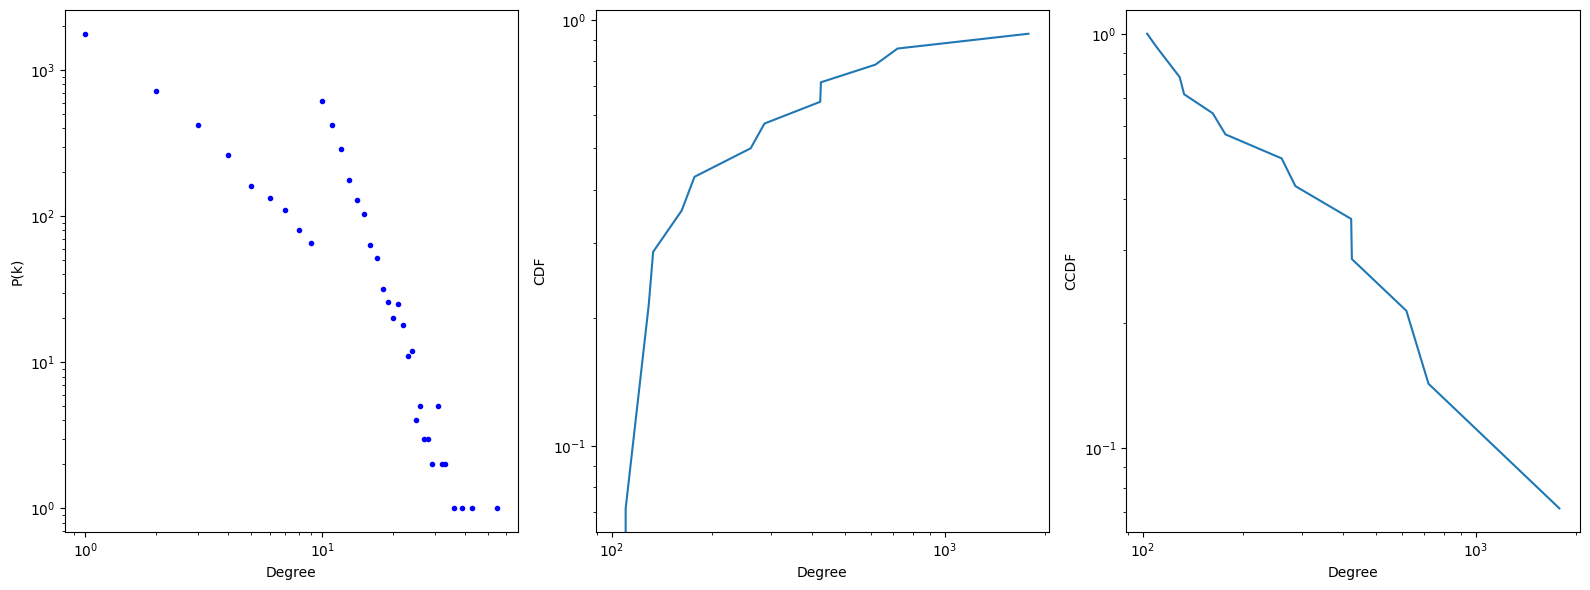

In [24]:
upregulated_graph_analysis = print_analysis(upregulated_graph)
plot_dist(upregulated_graph)

In [25]:
large_hub_nodes = get_nodes_with_certain_degree(upregulated_graph, (24, 55))
print("Number of Selected Hubs: ", len(large_hub_nodes))
print("Hubs: ", large_hub_nodes)

Number of Selected Hubs:  42
Hubs:  ['Ndufs2', 'Fau', 'Hsp90ab1', 'Got1', 'Got2', 'Gpi1', 'Rps27a', 'Rpl23', 'Sin3a', 'Hdac1', 'Stat3', 'Rptor', 'Mtor', 'Ndufs8', 'Mgll', 'Egfr', 'Cyp2e1', 'Cyp1a1', 'Cyp1a2', 'Cyp19a1', 'Hpgds', 'Alox15', 'Ranbp2', 'Polr2e', 'Apob', 'Trp53', 'Jun', 'Ugt2b1', 'Gnaq', 'F2', 'Calml3', 'Calm5', 'Calml4', 'Calm3', 'Ppargc1a', 'Grb2', 'Eprs', 'Gria2', 'Gria1', 'Dlg4', 'Rbx1', 'Kdr']


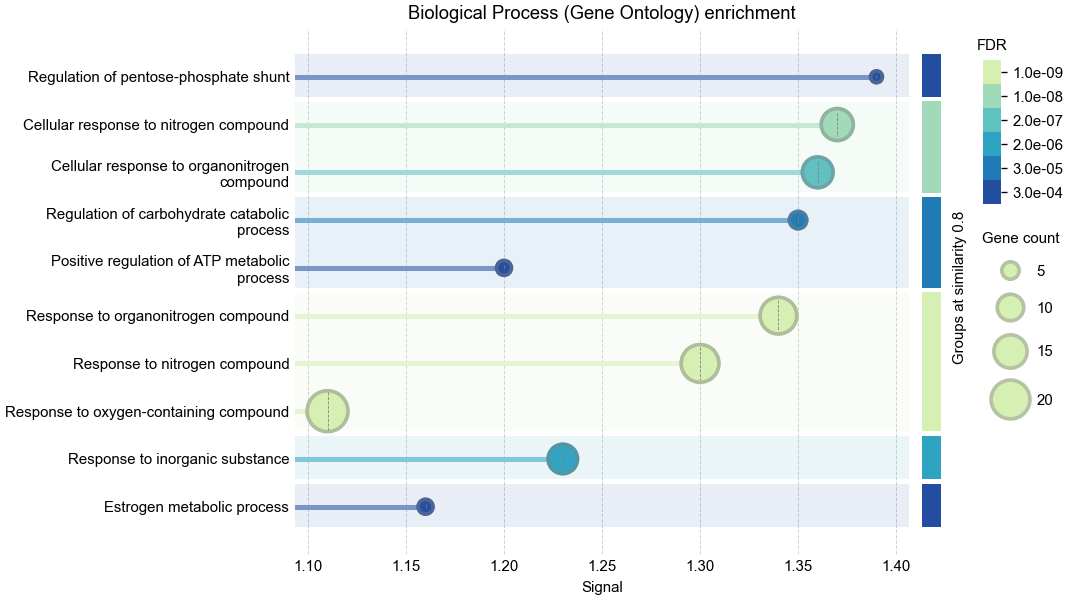

In [26]:
enrichment_figure = stringdb_api.get_enrichment_figure(large_hub_nodes, ["KEGG", "Process"])
display(Image(data=enrichment_figure))

1. **Regulation of pentose-phosphate shunt:**
   This process controls the activity of a metabolic pathway that helps cells produce molecules needed for energy and to protect against oxidative stress. It’s important for maintaining cell health and supporting growth.

2. **Cellular response to nitrogen compound:**
   This refers to how cells detect and react to substances that contain nitrogen, such as ammonia or nitric oxide. The response can involve changing gene activity or metabolism to adapt to these compounds.

3. **Cellular response to organonitrogen compound:**
   Similar to the previous term, this describes how cells respond to nitrogen-containing organic molecules — for example, amino acids or certain drugs. It highlights how cells adjust their behavior when exposed to these types of chemicals.


## Combined Network

Graph has 8795 nodes and 32313 edges.

Degree analysis:
	Average degree: 7.35
	Max degree: 69
	Min degree: 0

Connectedness analysis:
	Number of connected components: 303
	Size of largest connected component: 8408
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 16
	Average shortest path length of largest connected component: 5.905750888124244

Clustering and Density analysis:
	Average clustering coefficient: 0.280296866272173
	Graph density: 0.0008355741026073


Centrality analysis:
	Average betweenness centrality: 0.0005098943197677923
	Max betweenness centrality: 0.04706467519151646
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.1572227385982518
	Max closeness centrality: 0.2392899281408215
	Min closeness centrality: 0.0


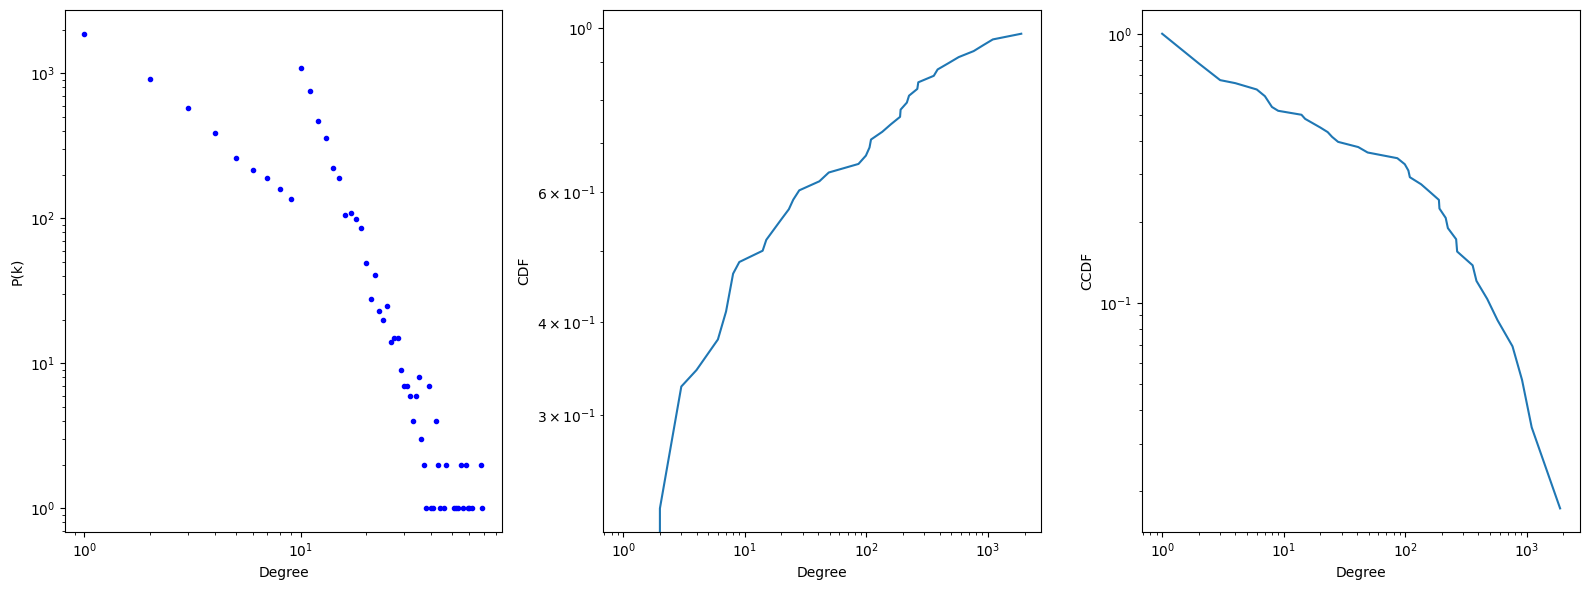

In [27]:
combined_graph_analysis = print_analysis(combined_graph)
plot_dist(combined_graph)

In [28]:
large_hub_nodes = get_nodes_with_certain_degree(combined_graph, (35, 69))
print("Number of Selected Hubs: ", len(large_hub_nodes))
print("Hubs: ", large_hub_nodes)

Number of Selected Hubs:  47
Hubs:  ['Jak2', 'Egfr', 'Crebbp', 'Src', 'F2', 'Alb', 'Fn1', 'Itgb1', 'Cd44', 'Tlr4', 'Hspa5', 'Rhoa', 'Syk', 'Cd4', 'Tnf', 'Apoa1', 'Trp53', 'Cyp1a2', 'Cyp2e1', 'Cyp1a1', 'Cdc42', 'Grb2', 'Ptk2', 'Actb', 'Kdr', 'Apob', 'Ptpn11', 'Ctnnb1', 'Calm3', 'Kras', 'Dlg4', 'Tyrobp', 'Akt1', 'Prkacb', 'Prkaca', 'Calm4', 'Calm5', 'Calml3', 'Jun', 'Traf6', 'Ppargc1a', 'Hdac1', 'Gnaq', 'Rbx1', 'Fau', 'Rps27a', 'Eprs']


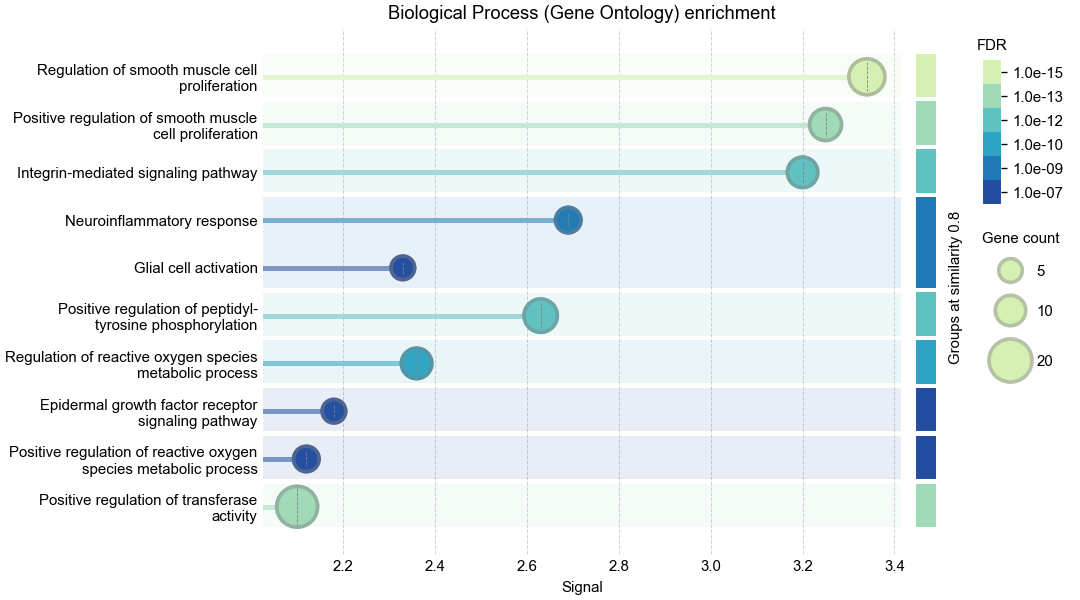

In [29]:
enrichment_figure = stringdb_api.get_enrichment_figure(large_hub_nodes, ["KEGG", "Process"])
display(Image(data=enrichment_figure))

## ER and BA null models

Graph has 6858 nodes and 21856 edges.

Degree analysis:
	Average degree: 6.37
	Max degree: 17
	Min degree: 0

Connectedness analysis:
	Number of connected components: 14
	Size of largest connected component: 6845
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 10
	Average shortest path length of largest connected component: 4.980487832992296

Clustering and Density analysis:
	Average clustering coefficient: 0.0009981884872523542
	Graph density: 0.0009295420640112368


Centrality analysis:
	Average betweenness centrality: 0.0005783853910488115
	Max betweenness centrality: 0.003752468856484645
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.200589379885105
	Max closeness centrality: 0.2295216936478328
	Min closeness centrality: 0.0


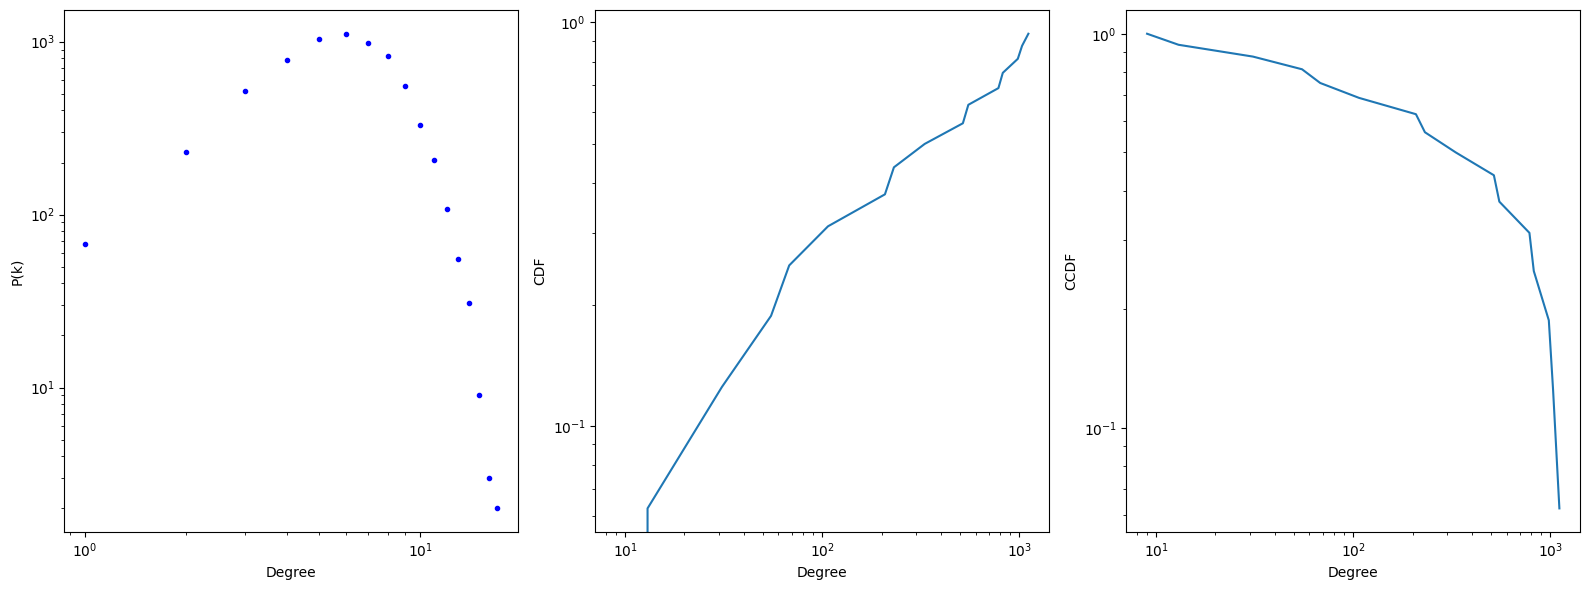

In [30]:
er_down = get_ER_graph(downregulated_graph.number_of_nodes(), downregulated_graph.number_of_edges())
er_down_analysis = print_analysis(er_down)
plot_dist(er_down)

Graph has 5871 nodes and 17005 edges.

Degree analysis:
	Average degree: 5.79
	Max degree: 17
	Min degree: 0

Connectedness analysis:
	Number of connected components: 26
	Size of largest connected component: 5846
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 11
	Average shortest path length of largest connected component: 5.140779991261307

Clustering and Density analysis:
	Average clustering coefficient: 0.0007796004219100795
	Graph density: 0.0009868620543270318


Centrality analysis:
	Average betweenness centrality: 0.0006995378074362639
	Max betweenness centrality: 0.00534372173887977
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.1935479634118159
	Max closeness centrality: 0.22365240262823458
	Min closeness centrality: 0.0


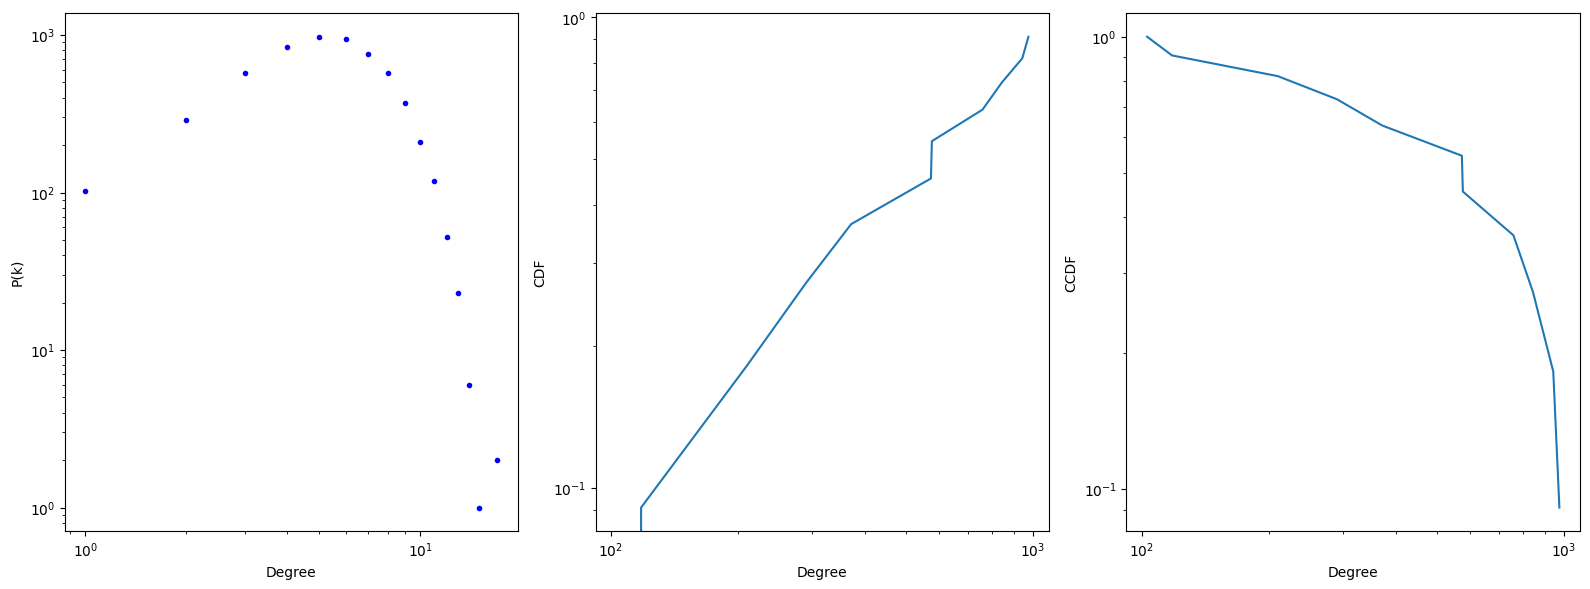

In [31]:
er_up = get_ER_graph(upregulated_graph.number_of_nodes(), upregulated_graph.number_of_edges())
er_up_analysis = print_analysis(er_up)
plot_dist(er_up)

Graph has 8795 nodes and 32610 edges.

Degree analysis:
	Average degree: 7.42
	Max degree: 21
	Min degree: 0

Connectedness analysis:
	Number of connected components: 8
	Size of largest connected component: 8788
	Is the graph connected? False

Largest Component Path analysis:
	Diameter of largest connected component: 9
	Average shortest path length of largest connected component: 4.759971502777073

Clustering and Density analysis:
	Average clustering coefficient: 0.0007820919229473555
	Graph density: 0.0008432541542420714


Centrality analysis:
	Average betweenness centrality: 0.00042692919038521225
	Max betweenness centrality: 0.0029583400623176084
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.21019986408405844
	Max closeness centrality: 0.2414211826875521
	Min closeness centrality: 0.0


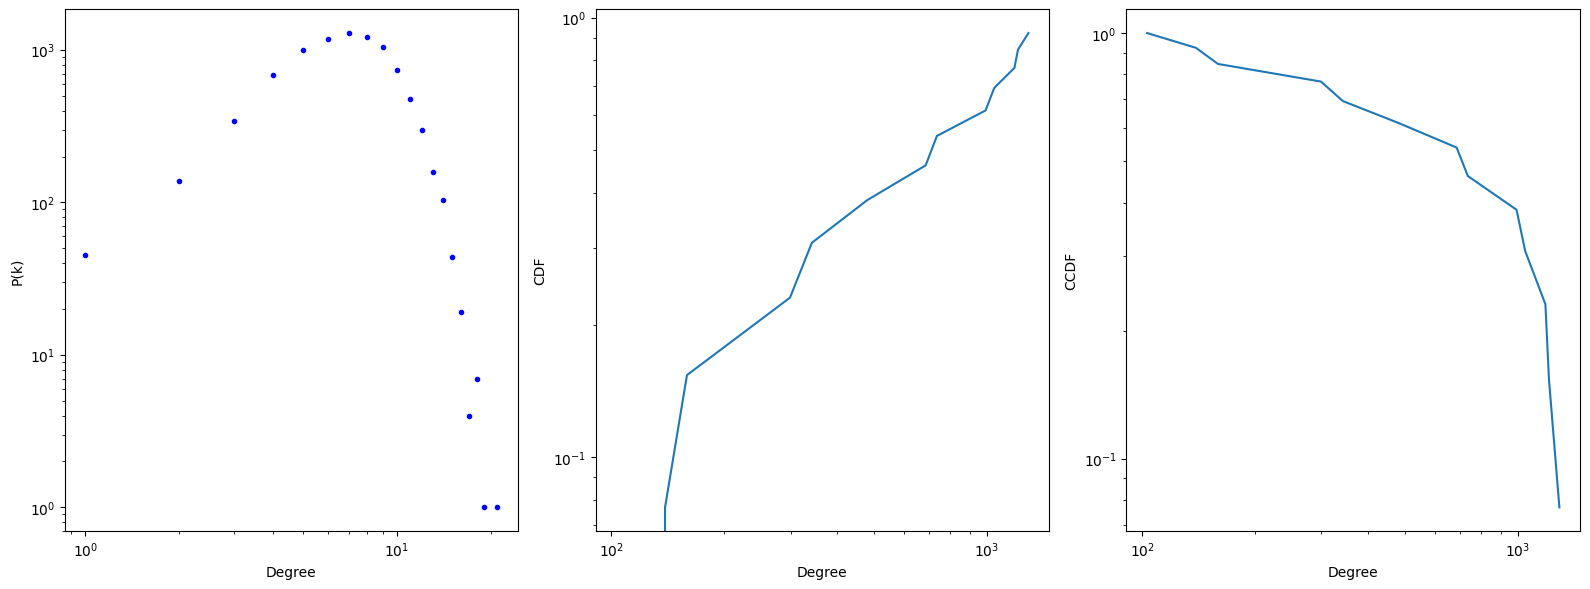

In [32]:
er_comb = get_ER_graph(combined_graph.number_of_nodes(), combined_graph.number_of_edges())
er_comb_analysis = print_analysis(er_comb)
plot_dist(er_comb)

Graph has 6858 nodes and 20565 edges.

Degree analysis:
	Average degree: 6.00
	Max degree: 188
	Min degree: 3

Connectedness analysis:
	Number of connected components: 1
	Size of largest connected component: 6858
	Is the graph connected? True

Largest Component Path analysis:
	Diameter of largest connected component: 7
	Average shortest path length of largest connected component: 4.170657985723687

Clustering and Density analysis:
	Average clustering coefficient: 0.006873960310692258
	Graph density: 0.0008746354569176009


Centrality analysis:
	Average betweenness centrality: 0.00046246470036809896
	Max betweenness centrality: 0.08472132331928273
	Min betweenness centrality: 3.5881184943135686e-06
	Average closeness centrality: 0.24137246521173897
	Max closeness centrality: 0.36380517826825126
	Min closeness centrality: 0.19445310949153505


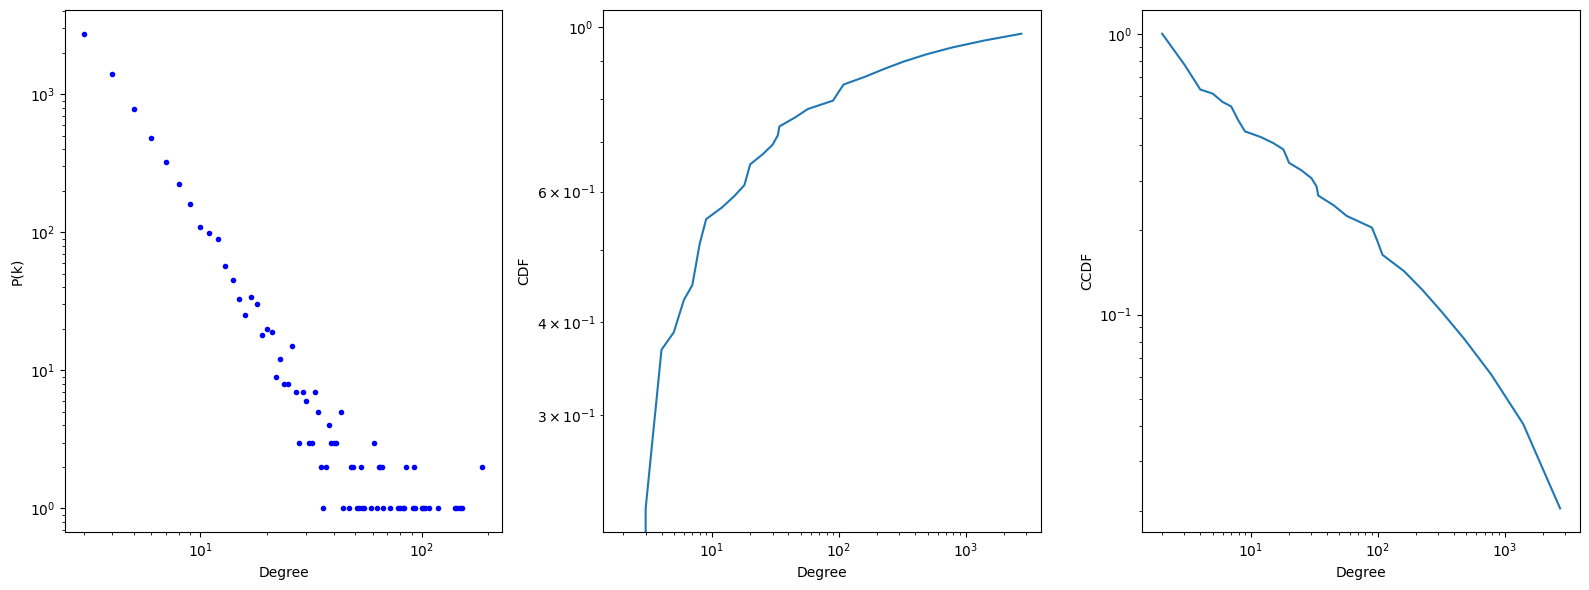

In [33]:
ba_down = get_BA_graph(downregulated_graph.number_of_nodes(), int(downregulated_graph_analysis["avg_degree"] / 2))
ba_down_analysis = print_analysis(ba_down)
plot_dist(ba_down)

Graph has 5871 nodes and 11738 edges.

Degree analysis:
	Average degree: 4.00
	Max degree: 164
	Min degree: 2

Connectedness analysis:
	Number of connected components: 1
	Size of largest connected component: 5871
	Is the graph connected? True

Largest Component Path analysis:
	Diameter of largest connected component: 8
	Average shortest path length of largest connected component: 4.859705763640009

Clustering and Density analysis:
	Average clustering coefficient: 0.006937707546301514
	Graph density: 0.0006811988705492913


Centrality analysis:
	Average betweenness centrality: 0.0006576428290407239
	Max betweenness centrality: 0.17535466119139737
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.20792538313115894
	Max closeness centrality: 0.33689164370982555
	Min closeness centrality: 0.15802934446089648


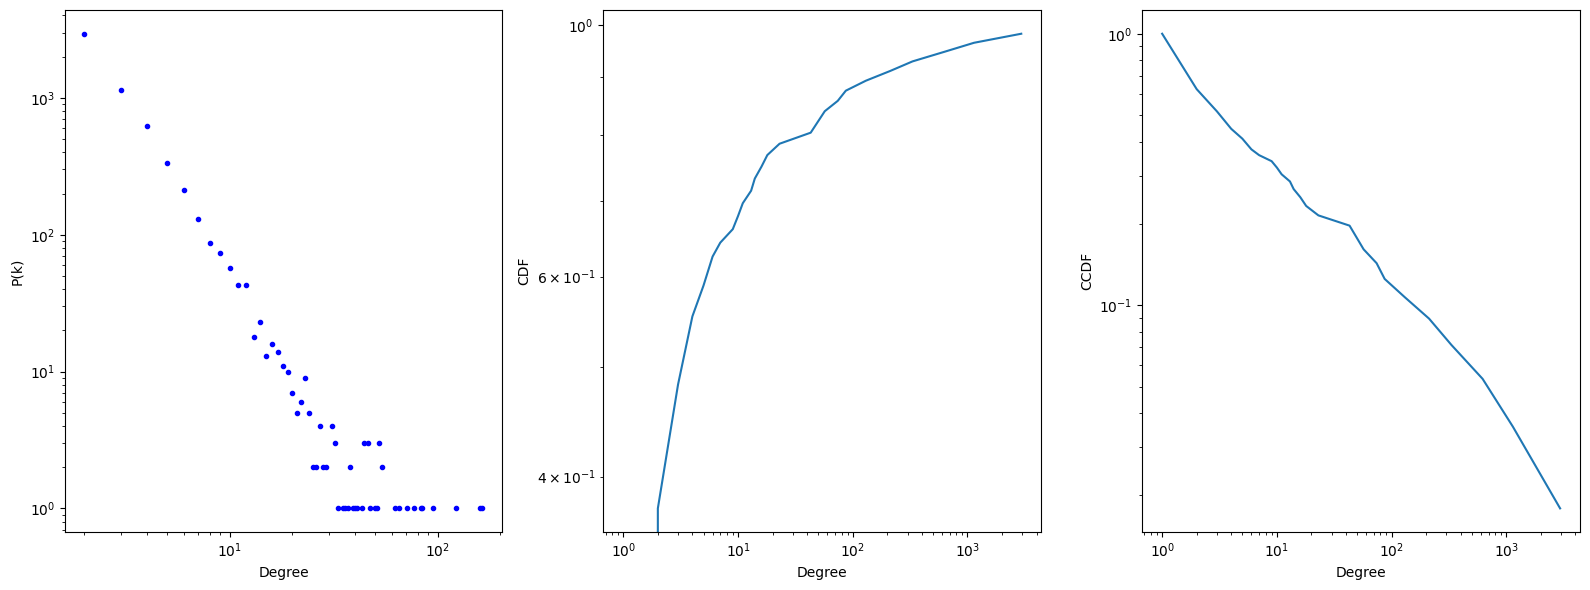

In [2]:
ba_up = get_BA_graph(upregulated_graph.number_of_nodes(), int(upregulated_graph_analysis["avg_degree"] / 2))
ba_up_analysis = print_analysis(ba_up)
plot_dist(ba_up)


Graph has 8795 nodes and 26376 edges.

Degree analysis:
	Average degree: 6.00
	Max degree: 274
	Min degree: 3

Connectedness analysis:
	Number of connected components: 1
	Size of largest connected component: 8795
	Is the graph connected? True

Largest Component Path analysis:
	Diameter of largest connected component: 7
	Average shortest path length of largest connected component: 4.229744374523794

Clustering and Density analysis:
	Average clustering coefficient: 0.005705949760032265
	Graph density: 0.0006820506461910112


Centrality analysis:
	Average betweenness centrality: 0.0003673085834781979
	Max betweenness centrality: 0.11516123153582529
	Min betweenness centrality: 2.5170511796942083e-06
	Average closeness centrality: 0.23800394001098243
	Max closeness centrality: 0.3679959827593422
	Min closeness centrality: 0.19224799422862515


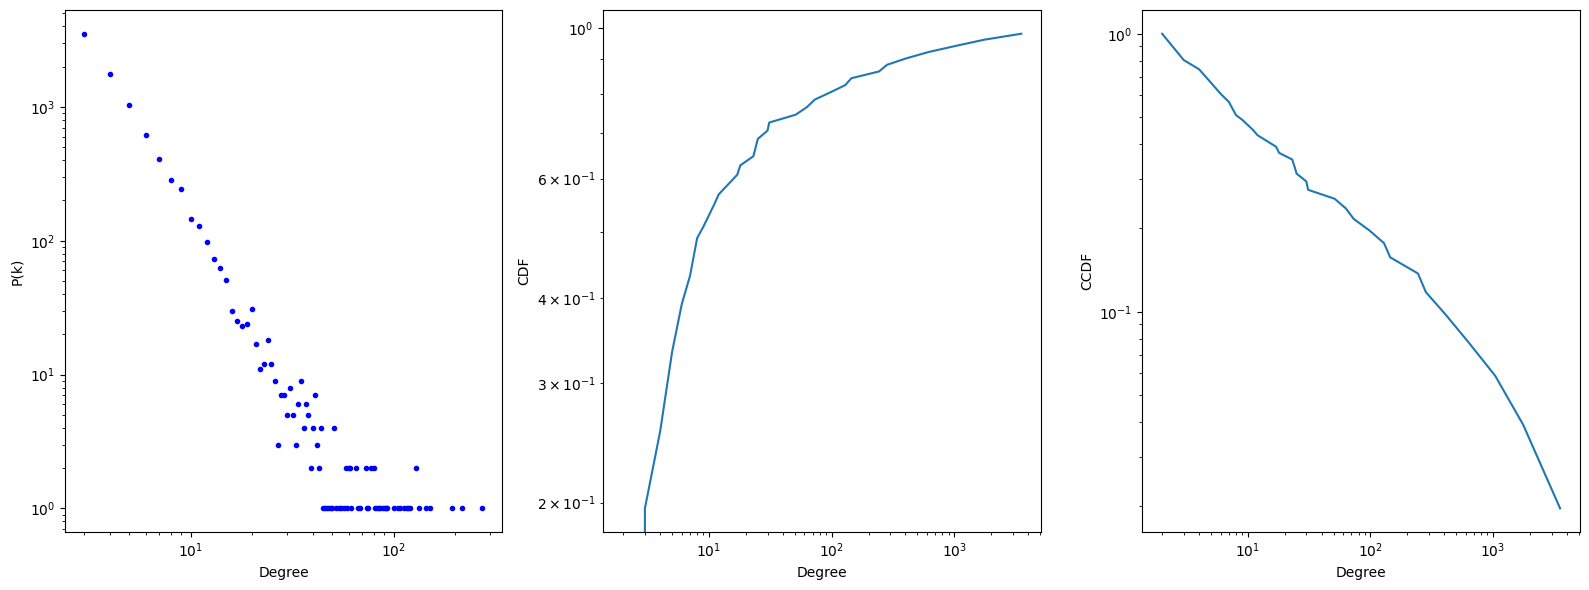

In [3]:
ba_comb = get_BA_graph(combined_graph.number_of_nodes(), int(combined_graph_analysis["avg_degree"] / 2))
ba_comb_analysis = print_analysis(ba_comb)
plot_dist(ba_comb)

# Table Comparison

In [ ]:
sum(downregulated_graph_analysis["betweenness_centrality"].values()) / len()

4.70382330383536

In [12]:
data = {
    "Experiment": ["Downregulated", "Upregulated", "Combined", "ER Downregulated", "ER Upregulated", "ER Combined", "BA Downregulated", "BA Upregulated", "BA Combined"],
    "Nodes": [downregulated_graph.number_of_nodes(), upregulated_graph.number_of_nodes(), combined_graph.number_of_nodes(), er_down.number_of_nodes(), er_up.number_of_nodes(), er_comb.number_of_nodes(), ba_down.number_of_nodes(), ba_up.number_of_nodes(), ba_comb.number_of_nodes()],
    "Edges": [downregulated_graph.number_of_edges(), upregulated_graph.number_of_edges(), combined_graph.number_of_edges(), er_down.number_of_edges(), er_up.number_of_edges(), er_comb.number_of_edges(), ba_down.number_of_edges(), ba_up.number_of_edges(), ba_comb.number_of_edges()],
    "Max Degree": [downregulated_graph_analysis["max_degree"], upregulated_graph_analysis["max_degree"], combined_graph_analysis["max_degree"], er_down_analysis["max_degree"], er_up_analysis["max_degree"], er_comb_analysis["max_degree"], ba_down_analysis["max_degree"], ba_up_analysis["max_degree"], ba_comb_analysis["max_degree"]],
    "Min Degree": [downregulated_graph_analysis["min_degree"], upregulated_graph_analysis["min_degree"], combined_graph_analysis["min_degree"], er_down_analysis["min_degree"], er_up_analysis["min_degree"], er_comb_analysis["min_degree"], ba_down_analysis["min_degree"], ba_up_analysis["min_degree"], ba_comb_analysis["min_degree"]],
    "Avg Degree": [downregulated_graph_analysis["avg_degree"], upregulated_graph_analysis["avg_degree"], combined_graph_analysis["avg_degree"], er_down_analysis["avg_degree"], er_up_analysis["avg_degree"], er_comb_analysis["avg_degree"], ba_down_analysis["avg_degree"], ba_up_analysis["avg_degree"], ba_comb_analysis["avg_degree"]],
    "Density": [downregulated_graph_analysis["density"], upregulated_graph_analysis["density"], combined_graph_analysis["density"], er_down_analysis["density"], er_up_analysis["density"], er_comb_analysis["density"], ba_down_analysis["density"], ba_up_analysis["density"], ba_comb_analysis["density"]],
    "Avg Clustering Coeff.": [downregulated_graph_analysis["avg_clustering"], upregulated_graph_analysis["avg_clustering"], combined_graph_analysis["avg_clustering"], er_down_analysis["avg_clustering"], er_up_analysis["avg_clustering"], er_comb_analysis["avg_clustering"], ba_down_analysis["avg_clustering"], ba_up_analysis["avg_clustering"], ba_comb_analysis["avg_clustering"]],
    "Avg Betweenness Centrality": [
        sum(downregulated_graph_analysis["betweenness_centrality"].values()) / len(downregulated_graph.nodes()),
        sum(upregulated_graph_analysis["betweenness_centrality"].values()) / len(upregulated_graph.nodes()),
        sum(combined_graph_analysis["betweenness_centrality"].values()) / len(combined_graph.nodes()),
        sum(er_down_analysis["betweenness_centrality"].values()) / len(er_down.nodes()),
        sum(er_up_analysis["betweenness_centrality"].values()) / len(er_up.nodes()),
        sum(er_comb_analysis["betweenness_centrality"].values()) / len(er_comb.nodes()),
        sum(ba_down_analysis["betweenness_centrality"].values()) / len(ba_down.nodes()),
        sum(ba_up_analysis["betweenness_centrality"].values()) / len(ba_up.nodes()),
        sum(ba_comb_analysis["betweenness_centrality"].values()) / len(ba_comb.nodes())
    ],
    "Avg Closeness Centrality": [
        sum(downregulated_graph_analysis["closeness_centrality"].values()) / len(downregulated_graph.nodes()),
        sum(upregulated_graph_analysis["closeness_centrality"].values()) / len(upregulated_graph.nodes()),
        sum(combined_graph_analysis["closeness_centrality"].values()) / len(combined_graph.nodes()),
        sum(er_down_analysis["closeness_centrality"].values()) / len(er_down.nodes()),
        sum(er_up_analysis["closeness_centrality"].values()) / len(er_up.nodes()),
        sum(er_comb_analysis["closeness_centrality"].values()) / len(er_comb.nodes()),
        sum(ba_down_analysis["closeness_centrality"].values()) / len(ba_down.nodes()),
        sum(ba_up_analysis["closeness_centrality"].values()) / len(ba_up.nodes()),
        sum(ba_comb_analysis["closeness_centrality"].values()) / len(ba_comb.nodes())
    ],
    "Num CC": [downregulated_graph_analysis["num_cc"], upregulated_graph_analysis["num_cc"], combined_graph_analysis["num_cc"], er_down_analysis["num_cc"], er_up_analysis["num_cc"], er_comb_analysis["num_cc"], ba_down_analysis["num_cc"], ba_up_analysis["num_cc"], ba_comb_analysis["num_cc"]],
    "LCC Size": [len(downregulated_graph_analysis["largest_cc"]), len(upregulated_graph_analysis["largest_cc"]), len(combined_graph_analysis["largest_cc"]), len(er_down_analysis["largest_cc"]), len(er_up_analysis["largest_cc"]), len(er_comb_analysis["largest_cc"]), len(ba_down_analysis["largest_cc"]), len(ba_up_analysis["largest_cc"]), len(ba_comb_analysis["largest_cc"])],
    "LCC Diameter": [downregulated_graph_analysis["lcc_diameter"], upregulated_graph_analysis["lcc_diameter"], combined_graph_analysis["lcc_diameter"], er_down_analysis["lcc_diameter"], er_up_analysis["lcc_diameter"], er_comb_analysis["lcc_diameter"], ba_down_analysis["lcc_diameter"], ba_up_analysis["lcc_diameter"], ba_comb_analysis["lcc_diameter"]],
    "Avg Shortest Path Length": [downregulated_graph_analysis["lcc_avg_shortest_path"], upregulated_graph_analysis["lcc_avg_shortest_path"], combined_graph_analysis["lcc_avg_shortest_path"], er_down_analysis["lcc_avg_shortest_path"], er_up_analysis["lcc_avg_shortest_path"], er_comb_analysis["lcc_avg_shortest_path"], ba_down_analysis["lcc_avg_shortest_path"], ba_up_analysis["lcc_avg_shortest_path"], ba_comb_analysis["lcc_avg_shortest_path"]],
    "Avg Clustering Coeff.": [downregulated_graph_analysis["avg_clustering"], upregulated_graph_analysis["avg_clustering"], combined_graph_analysis["avg_clustering"], er_down_analysis["avg_clustering"], er_up_analysis["avg_clustering"], er_comb_analysis["avg_clustering"], ba_down_analysis["avg_clustering"], ba_up_analysis["avg_clustering"], ba_comb_analysis["avg_clustering"]],
}

df = pd.DataFrame(data)

# Simple table in Jupyter
display(df)


,Experiment,Nodes,Edges,Max Degree,Min Degree,Avg Degree,Density,Avg Clustering Coeff.,Avg Betweenness Centrality,Avg Closeness Centrality,Num CC,LCC Size,LCC Diameter,Avg Shortest Path Length
0,Downregulated,6858,21862,69,0,6.375620,0.000930,0.253793,0.000686,0.156766,182,6618,17,6.049726
1,Upregulated,5871,17408,55,0,5.930165,0.001010,0.256850,0.000872,0.147506,129,5686,14,6.456516
2,Combined,8795,32313,69,0,7.348039,0.000836,0.280297,0.000510,0.157223,303,8408,16,5.905751
3,ER Downregulated,6858,21856,17,0,6.373870,0.000930,0.000998,0.000578,0.200589,14,6845,10,4.980488
4,ER Upregulated,5871,17005,17,0,5.792880,0.000987,0.000780,0.000700,0.193548,26,5846,11,5.140780
5,ER Combined,8795,32610,21,0,7.415577,0.000843,0.000782,0.000427,0.210200,8,8788,9,4.759972
6,BA Downregulated,6858,20565,188,3,5.997375,0.000875,0.006874,0.000462,0.241372,1,6858,7,4.170658
7,BA Upregulated,5871,11738,164,2,3.998637,0.000681,0.006938,0.000658,0.207925,1,5871,8,4.859706
8,BA Combined,8795,26376,274,3,5.997953,0.000682,0.005706,0.000367,0.238004,1,8795,7,4.229744


In [ ]:
dill.dump_session("01_session.pkl")